## What data do you have and what additional data will you need?
Data downloaded from: https://data-downloads.evictionlab.org/  
Data dictionary: https://eviction-lab-data-downloads.s3.amazonaws.com/DATA_DICTIONARY.txt

The primary data that we intend to use is provided by the Eviction Lab at Princeton University. This data combines information on formal eviction records with Census demographic information. Notably, this data only includes court-ordered evictions made publically-available by municipalities (i.e., it excludes informal evictions, evictions from court-sealed cases, and evictions from localities without archived data).

This data is available annually at the Census block group level. Philadelphia County (conterminous with the city of Philadelphia) spans 1,336 block groups in the dataset, all of which have complete evictions data from 2002 through 2016. Thus, the relevant dataset that we intent to use to build and evaluate our models includes 20,040 records (i.e., 1,336 block groups across 15 years). Because the Eviction Lab provides data from municipalities across the country (albeit with varying levels of completeness), we can also create models incorporating data from other cities and evaluate how this affects the models' performance.

For a given block group and year, the following eviction information is available: 

- The number of eviction judgements in which renters were ordered to leave
- The number of eviction cases filed

And the following demographic information is available:

- The total population
- The percentage of the population with income in the past 12 months below the poverty level
- The percentage of occupied housing units that are renter-occupied
- The median gross rent
- The median household income
- The median property value
- The median gross rent as a percentage of household income
- The percentage of the population that is White, African American, Hispanic, Asian, etc.

From this data, an eviction rate (i.e., the ratio of evictions to renter-occupied households) for each block in a given year is also provided, along with an eviction filing rate. Each record also includes information indicating if that record's data is imputed, subbed, from non-Eviction Lab sources, and estimated to be lower than in reality.

The demographic data provided in the Eviction Lab data primarily relies on the following:

- 2000 Census for 2000-2004
- 2009 5-year ACS for 2005-2009
- 2010 Census for 2010
- 2015 5-year ACS for 2011-2016

Because the data is provided at a Census block group level and includes the Census FIPS code, additional Census data can easily be incorporated to supplement the existing information at the block group level.

## What are some basic descriptive statistics?
First, the data is limited to only include Philadelphia and to remove years with missing evictions data (i.e., 2000 and 2001). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format

# Load data 
df = pd.read_csv('data/block-groups_pa.csv')

# Limit data
df = df[df['parent-location'] == 'Philadelphia County, Pennsylvania']
df = df[df['year'] >= 2002]

The table below shows summary statistics on the number of evictions, number of eviction filings, eviction rate, and eviction filing rate across the dataset. 

In [2]:
# Summarize distribution of target variable(s) 
df[['evictions', 
    'eviction-filings', 
    'eviction-rate', 
    'eviction-filing-rate']].describe(percentiles=[.25, .5, .75, .95, .99]).round(1)

,evictions,eviction-filings,eviction-rate,eviction-filing-rate
count,"20,040.0","20,040.0","20,040.0","20,040.0"
mean,7.8,14.2,5.2,8.7
std,8.4,19.0,40.1,64.4
min,0.0,0.0,0.0,0.0
25%,2.0,4.0,1.6,2.7
50%,6.0,9.0,3.6,5.9
75%,10.0,18.0,6.0,10.0
95%,23.0,43.0,10.4,18.0
99%,41.0,91.6,15.1,29.9
max,128.0,404.0,"2,777.8","6,666.7"


The table below shows how this data changes over time. Specifically, the table below shows how the total number of evictions, total number of eviction filings, average eviction rate, and average eviction filing rate change over time.

In [3]:
# Summarize change over time 
df.groupby('year').agg(
    {'evictions':'sum', 
     'eviction-filings':'sum', 
     'eviction-rate':'mean', 
     'eviction-filing-rate':'mean'}).round(1)

,evictions,eviction-filings,eviction-rate,eviction-filing-rate
year,,,,
2002,"6,485.0","8,176.0",3.5,4.1
2003,"10,647.0","13,502.0",5.6,6.7
2004,"10,491.0","13,268.0",5.4,6.5
2005,"10,550.0","13,203.0",5.8,6.8
2006,"11,078.0","13,867.0",6.9,8.1
2007,"11,032.0","21,442.0",5.1,9.0
2008,"10,866.0","21,276.0",6.1,9.9
2009,"9,821.0","19,878.0",5.8,12.7
2010,"10,628.0","22,669.0",4.4,8.6


The figure below visualizes how the total number evictions and total number of eviction filings change over time.

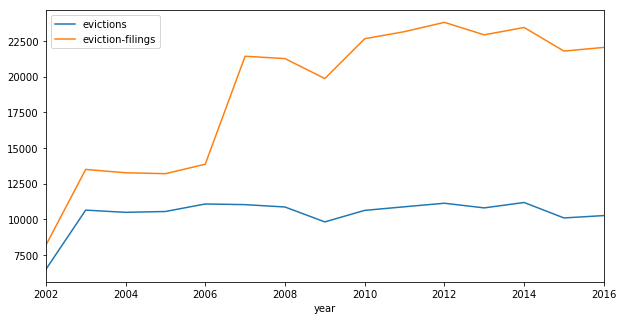

In [4]:
# Plot change in totals over time 
df.groupby(['year'])['evictions', 
                     'eviction-filings'].sum().plot(figsize=(10, 5))

And the figure below visualizes how the average number evictions, eviction filings, eviction rate, and eviction filing rate change over time.

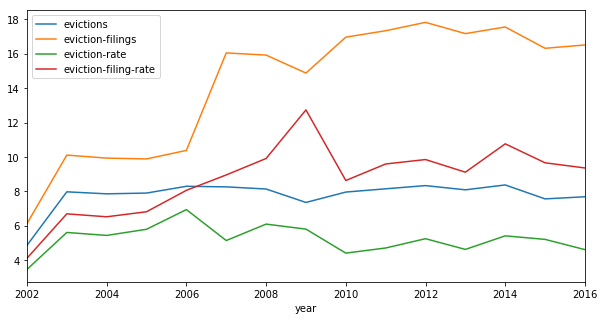

In [5]:
# Plot change in averages over time 
df.groupby(['year'])['evictions', 
                     'eviction-filings', 
                     'eviction-rate', 
                     'eviction-filing-rate'].mean().plot(figsize=(10, 5))

The figures below show the correlation between evictions and eviction filings (on the left), along with the eviction and eviction filing rate (on the right). To allow for the general relationship to be more easily visualized, block groups with more than 100 evictions or with an eviction rate of more than 25 aren't shown in their respective figures.

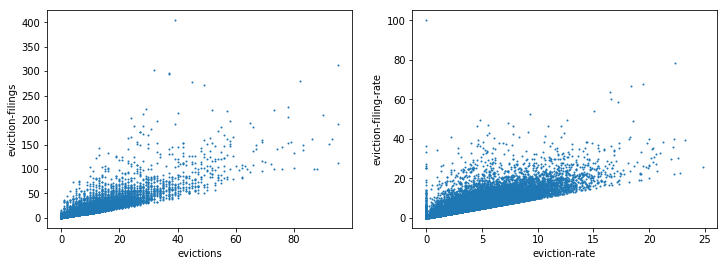

In [6]:
# Compare evictions to filings 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
df[df['evictions']<100].plot.scatter(x='evictions', y='eviction-filings', ax=ax1, s=1)
df[df['eviction-rate']<25].plot.scatter(x='eviction-rate', y='eviction-filing-rate', ax=ax2, s=1)
plt.show()   

The scatterplots below show the relationship between some of the potential features to include in the models and the number of evictions (on the left), and the eviction rate (on the right). As with the figures above, block groups with more than 100 evictions with an eviction rate of more than 50 aren't shown in their respective figures.

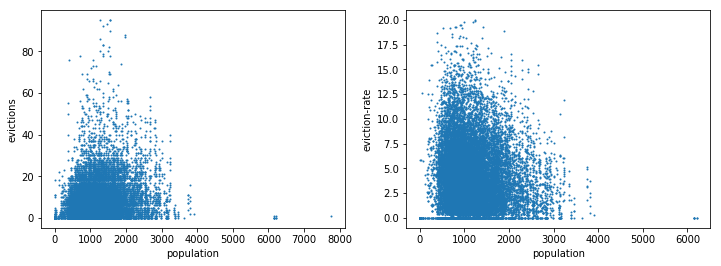

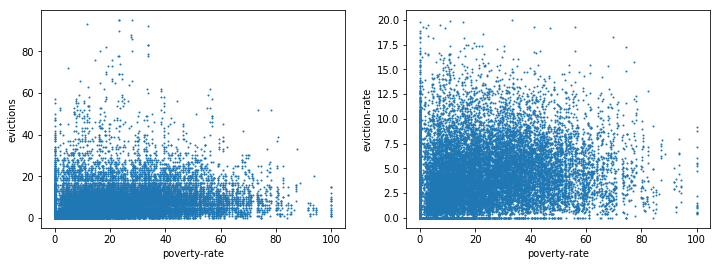

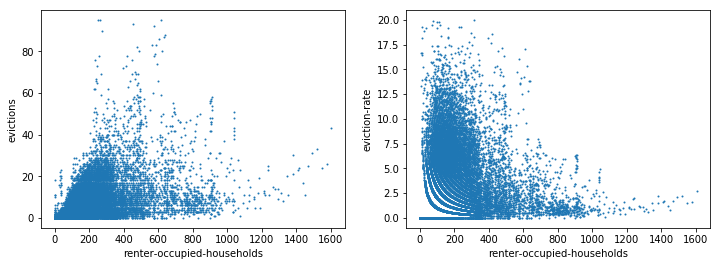

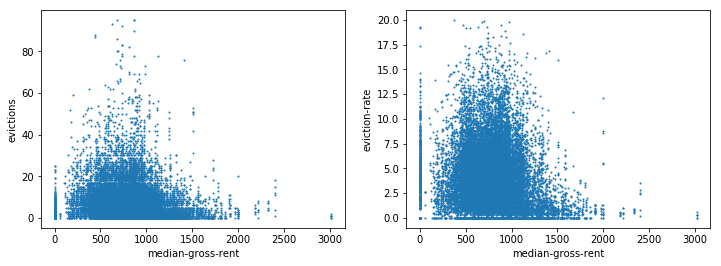

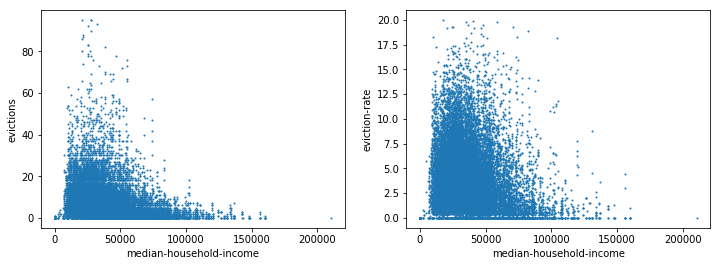

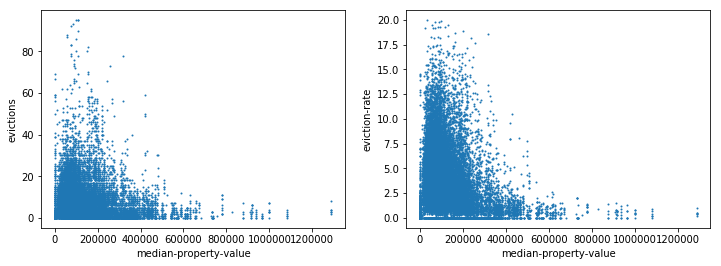

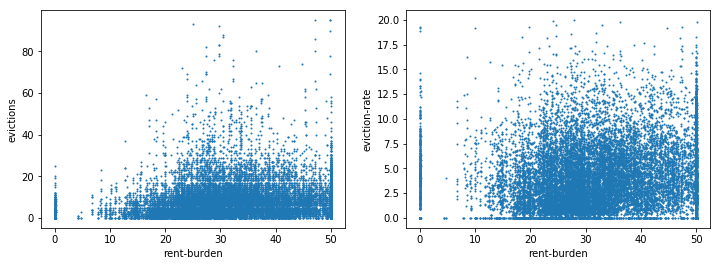

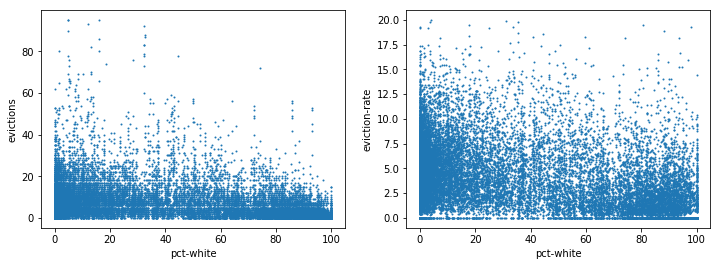

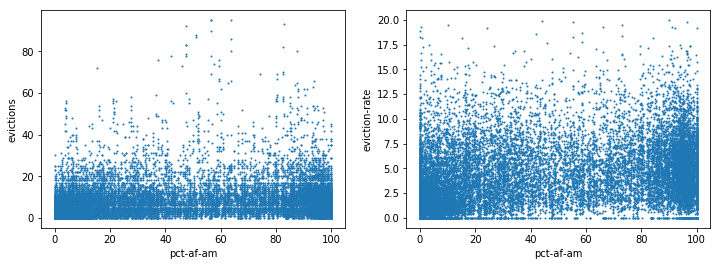

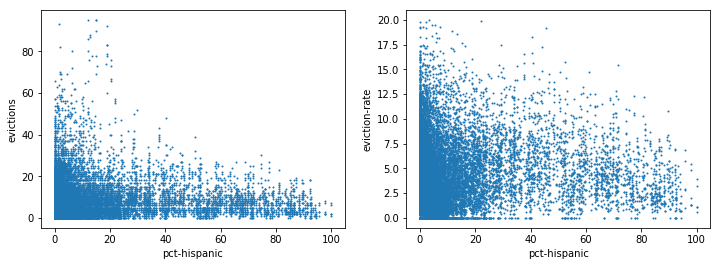

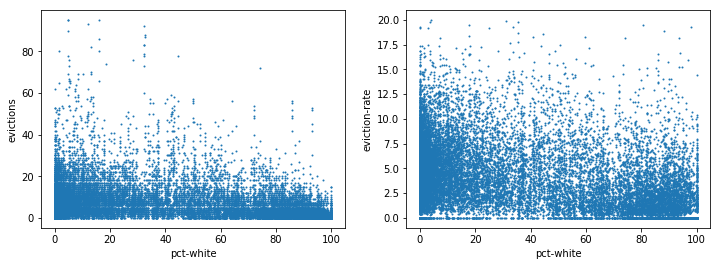

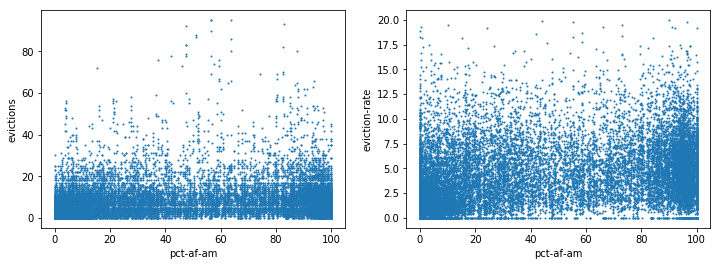

In [7]:
# Compare to features 
def create_scatter(feature): 
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
    df[df['evictions']<100].plot.scatter(x=feature, y='evictions', ax=ax1, s=1)
    df[df['eviction-rate']<20].plot.scatter(x=feature, y='eviction-rate', ax=ax2, s=1)
    plt.show()    
    
create_scatter('population')
create_scatter('poverty-rate')
create_scatter('renter-occupied-households')
create_scatter('median-gross-rent')
create_scatter('median-household-income')
create_scatter('median-property-value')
create_scatter('rent-burden')
create_scatter('pct-white')
create_scatter('pct-af-am')
create_scatter('pct-hispanic')
create_scatter('pct-white')
create_scatter('pct-af-am')

## What analysis are you proposing to do?
The fundamental goal of this analysis is to identify the block groups that are likely to have the highest eviction rates in the future, which requires predicting eviction rates by block group. In a machine learning context, we're solving a regression problem where our target is the eviction rate for each block group. Separately, we're also interested in predicting the difference between the filing rate and the eviction rate (i.e., the difference between eviction cases filed and judgements in which renters were actually ordered to leave), as this gap appears to be widening over time. 

Given that our model must be appropriate for regression where the target is a continuous variable, we intend to apply the following types of methods: 

- Simple linear regression
- Polynomial regression
- Support vector regression
- Decision tree regression
- Random forest regression

Because our data spans 15 years, we intend to apply temporal validation using various splits, with the intent of identifying the best model to predict future eviction rates. As previously noted, we intend to consider including data from other cities to train our models and compare their performance against models trained only on data from Philadelphia. 